In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
nn.sequential?

Object `nn.sequential` not found.


We will again use digits, this time with a MLP and then a CNN

In [5]:
from torchvision.transforms import ToTensor
from torchvision.datasets import EMNIST


In [6]:
training_data = EMNIST('./emnist', split='letters',train=True,  download=True, transform=ToTensor())
test_data = EMNIST('./emnist', split='letters',train=False,  download=True, transform=ToTensor())

In [7]:
training_data

Dataset EMNIST
    Number of datapoints: 124800
    Split: train
    Root Location: ./emnist
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [8]:
from torch.utils.data import DataLoader

Hyperparameters

In [9]:
BATCH_SIZE = 256
LEARNING_RATE = 0.01
WORKERS = 26

In [10]:
train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)
test_loader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=WORKERS, shuffle=True)

In [126]:
class MultiLayer(nn.Module):
    def __init__(self, shape=(28,28), num_classes=52):
        super().__init__()
        
        num_inputs = np.product(shape)
    
        self.layer1 = nn.Linear(num_inputs,50)
        self.layer2 = nn.Linear(50,100)
        self.layer3 = nn.Linear(100,num_classes)
        
    
    def forward(self, x):
        
        #Conv up here 
        
        x = x.reshape(x.shape[0], -1)
        h1 = self.layer1(x)
        h1 = F.relu(h1)
        h2 = self.layer2(h1)
        h2 = F.relu(h2)
        y = self.layer3(h2)
        
        return y  # Will learn to treat 'a' as the natural parameters of a multinomial distr. 

In [127]:
net = MultiLayer()

In [128]:
net

MultiLayer(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=52, bias=True)
)

In [129]:
net = MultiLayer(shape=(28, 28), num_classes=52)

In [130]:
net

MultiLayer(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=52, bias=True)
)

In [131]:
list(net.state_dict())

['layer1.weight',
 'layer1.bias',
 'layer2.weight',
 'layer2.bias',
 'layer3.weight',
 'layer3.bias']

## GPU (If Available)

In [132]:
import torch.cuda
torch.cuda.is_available()

False

In [133]:
if torch.cuda.is_available():
    def togpu(x):
        return x.cuda()
    def tocpu(x):
        return x.cpu()
else:
    def togpu(x):
        return x
    def tocpu(x):
        return x

In [134]:
net = togpu(net)

##  Setup loss & Optimizer __after__ net is put on GPU
The network must _already_ be on the GPU, otherwise the tensors that represent the parameters will be the CPU versions and _not_ the GPU version. See the call to `net.parameters()`

In [135]:
criterion = nn.CrossEntropyLoss()

In [136]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=LEARNING_RATE)

# Training Loop

In [137]:
num_epochs = 2

In [138]:
import time

In [139]:
#!pip install tqdm

In [140]:
import tqdm

In [141]:
for epoch in tqdm.tnrange(num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    for i, data in tqdm.tqdm(enumerate(train_loader),
                             file=sys.stdout,
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data

        # Move inputs to the GPU
        inputs = togpu(inputs)
        labels = togpu(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    tend = time.time()
    print("Epoch {: 4}   loss: {: 2.5f}  time: {}".format(epoch, 
                                                          running_loss / len(train_loader), 
                                                          tend-tstart))

Epoch    0   loss:  3.59152  time: 22.19662380218506
Epoch    1   loss:  2.80808  time: 22.47387981414795


In [142]:
def show_batch(images, targets, predictions=None):
    ncols = ceil(sqrt(len(images)))
    nrows = ceil(len(images)/ncols)
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if predictions is not None:
            xlabel("P:{}, T:{}".format( predictions[i].numpy(), targets[i].numpy()), fontsize='small')
        elif targets is not None:
            xlabel("T:{}".format(targets[i].numpy()))

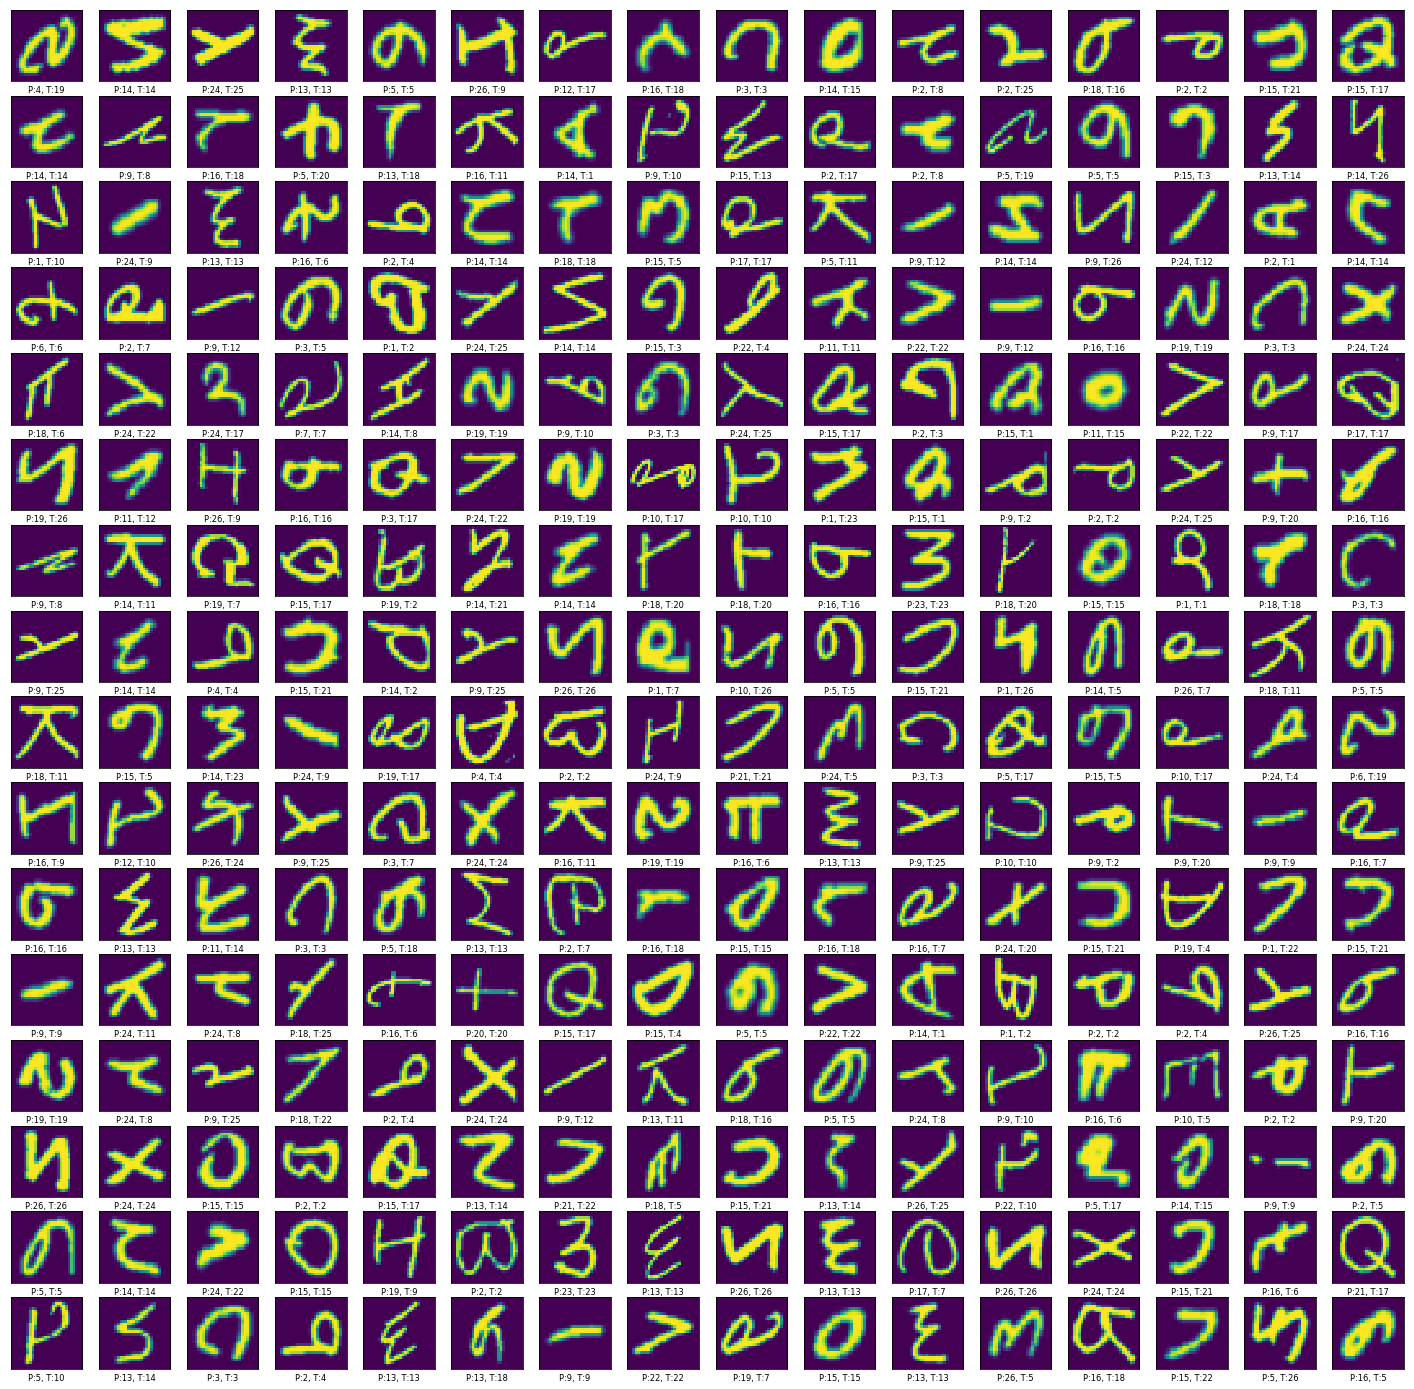

In [143]:
figsize(25,25)
eval_data, eval_target = iter(test_loader).next()
show_batch(eval_data, eval_target, 
           tocpu(net(togpu(eval_data))).detach().argmax(1))

In [144]:
start_epoch = 0
num_epochs = 30
best_epoch = 0
best_eval_loss = float('inf')

In [145]:
import shutil

In [146]:
def compute_eval_loss(net, loader):
    # Evaluate the model
    with torch.no_grad():
        eval_loss = 0.0
        for i, data in tqdm.tqdm(enumerate(loader),
                                 file = sys.stdout,
                                 desc='Evaluating',
                                 total=len(loader),
                                 leave=False):
            inputs, labels = data
            inputs, labels = togpu(inputs), togpu(labels)
            outputs = net(inputs)               # Predict
            loss = criterion(outputs, labels)   # Grade / Evaluate
            eval_loss += loss.item()
    eval_loss /= len(test_loader)
    return eval_loss

In [147]:
compute_eval_loss(net, test_loader)

2.4060377283174486

In [148]:
for epoch in tqdm.tnrange(start_epoch, num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    
    # Update the model parameters
    for i, data in tqdm.tqdm(enumerate(train_loader), 
                             file = sys.stdout,
                             desc='Updating',
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data
        
        # Move them to the GPU
        inputs = togpu(inputs)
        labels = togpu(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    running_loss /= len(train_loader)
    

    eval_loss = compute_eval_loss(net, test_loader)
    
    tend = time.time()
    
    # Save parameters
    torch.save(dict(epoch=epoch, 
                         loss=eval_loss,
                         parameters=net.state_dict(),
                         optimizer=optimizer.state_dict()),
                   'multilayer-checkpoint.pth.tar')
    
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_epoch = epoch
        shutil.copyfile('multilayer-checkpoint.pth.tar', 'multilayer-best.pth.tar')
        
    print("Epoch {: 4}   loss: {: 2.5f}  test-loss: {: 2.5}  time: {}".format(epoch,
                                                                                running_loss,
                                                                                eval_loss,
                                                                                tend-tstart))

Epoch    0   loss:  2.09740  test-loss:  1.8498  time: 48.20305395126343
Epoch    1   loss:  1.69549  test-loss:  1.5694  time: 46.400874853134155
Epoch    2   loss:  1.48642  test-loss:  1.415  time: 47.276652812957764
Epoch    3   loss:  1.36172  test-loss:  1.3184  time: 46.42926549911499
Epoch    4   loss:  1.27722  test-loss:  1.2458  time: 46.43566846847534
Epoch    5   loss:  1.21653  test-loss:  1.1906  time: 42.844061613082886
Epoch    6   loss:  1.16807  test-loss:  1.1491  time: 43.134647846221924
Epoch    7   loss:  1.12679  test-loss:  1.1091  time: 44.2309844493866
Epoch    8   loss:  1.08988  test-loss:  1.0696  time: 41.36733865737915
Epoch    9   loss:  1.05466  test-loss:  1.0359  time: 41.126479387283325
Epoch   10   loss:  1.02112  test-loss:  1.0082  time: 41.97272300720215
Epoch   11   loss:  0.98802  test-loss:  0.97256  time: 42.19784951210022
Epoch   12   loss:  0.95642  test-loss:  0.93985  time: 41.426180839538574
Epoch   13   loss:  0.92516  test-loss:  0.91

# the GPU Utilization during training:
```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.77                 Driver Version: 390.77                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   40C    P2    58W / 250W |    539MiB / 11178MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   25C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  GeForce GTX 108...  Off  | 00000000:0C:00.0 Off |                  N/A |
| 20%   26C    P8     9W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   3  GeForce GTX 108...  Off  | 00000000:0E:00.0 Off |                  N/A |
| 20%   26C    P8     9W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0     38289      C   ...mianjc/anaconda3/envs/CSE470/bin/python   529MiB |
+-----------------------------------------------------------------------------+
```

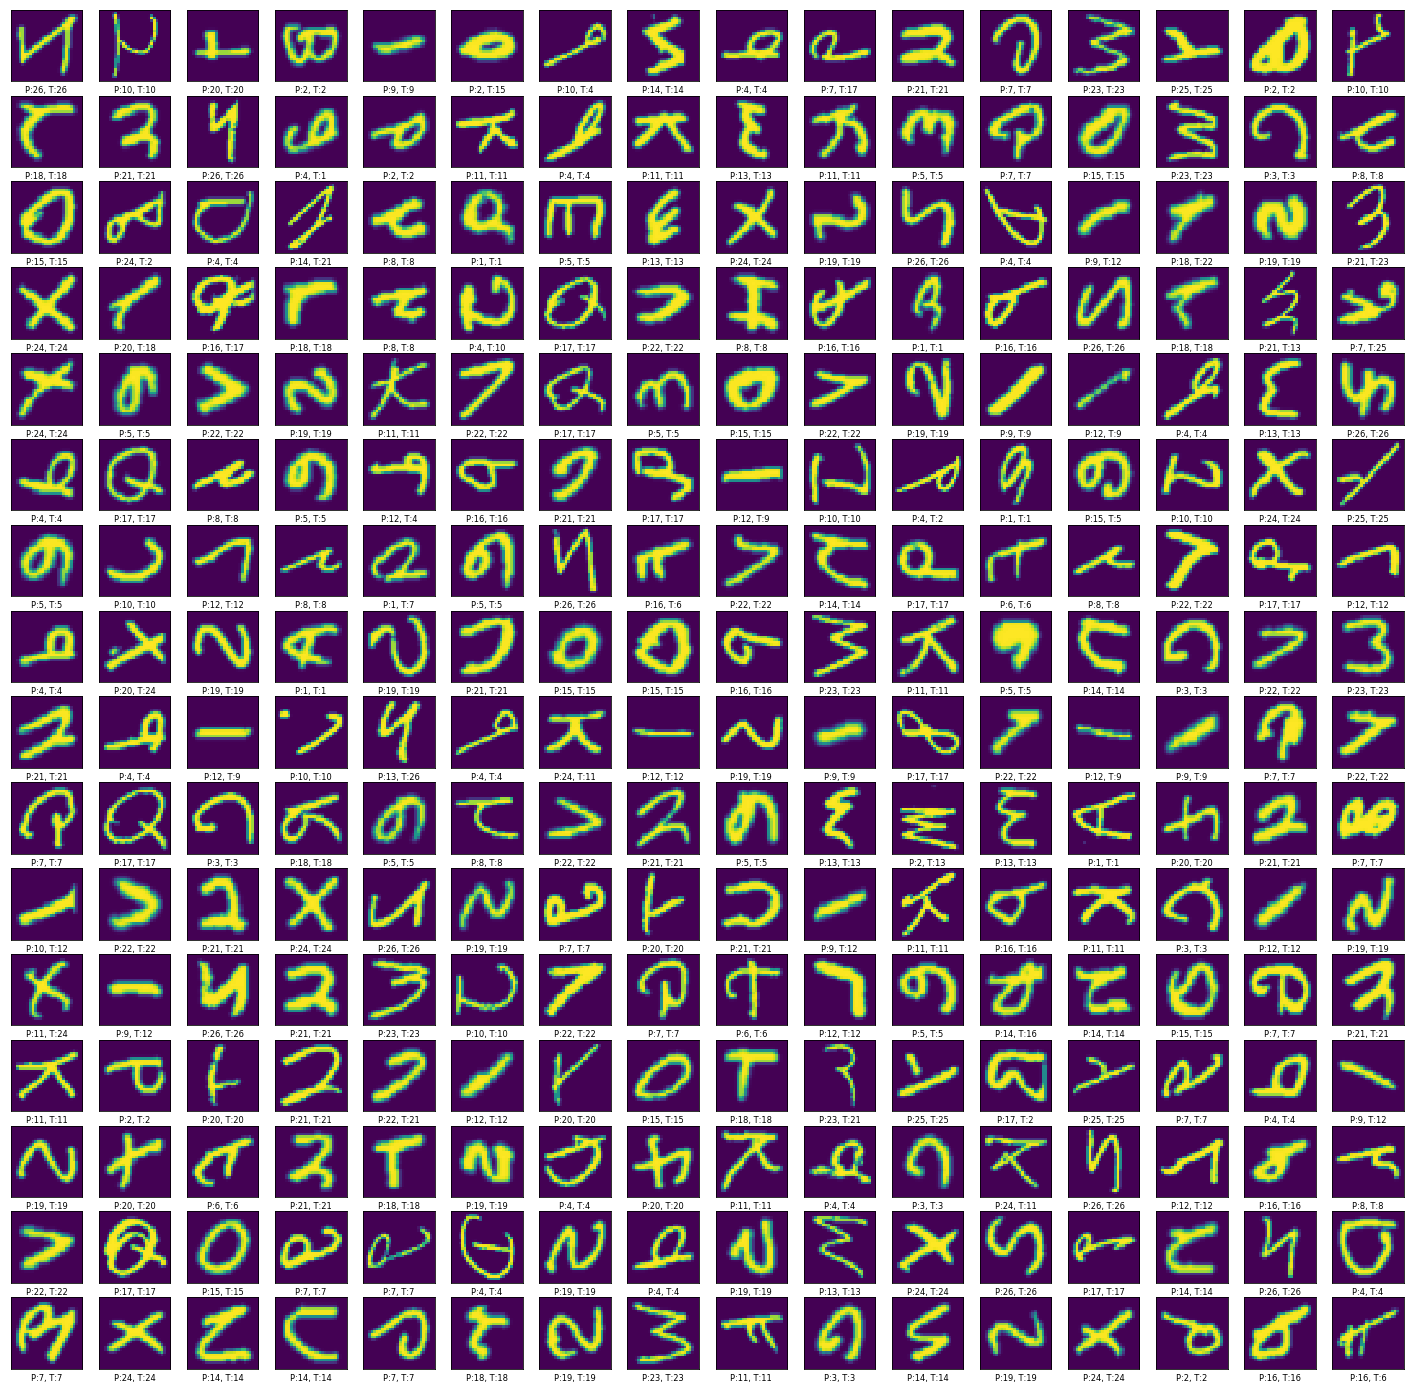

In [149]:
eval_data, eval_target = iter(test_loader).next()
show_batch(eval_data, eval_target, tocpu(net(togpu(eval_data))).detach().argmax(1))

In [150]:
predictions = np.zeros(len(test_data))
targets = np.zeros(len(test_data))

for i  in tqdm.tnrange(len(test_data)):
    x, t = test_data[i]
    p = tocpu(net(togpu(x[None,...]))).argmax(1)[0]
    predictions[i] = int(p)
    targets[i] = t

In [151]:
from sklearn.metrics import classification_report

In [152]:
print(classification_report(targets, predictions))

             precision    recall  f1-score   support

        1.0       0.75      0.67      0.71       800
        2.0       0.79      0.86      0.82       800
        3.0       0.88      0.86      0.87       800
        4.0       0.81      0.77      0.79       800
        5.0       0.81      0.83      0.82       800
        6.0       0.83      0.84      0.84       800
        7.0       0.68      0.61      0.64       800
        8.0       0.71      0.83      0.77       800
        9.0       0.70      0.65      0.68       800
       10.0       0.84      0.83      0.83       800
       11.0       0.82      0.79      0.80       800
       12.0       0.65      0.77      0.71       800
       13.0       0.89      0.91      0.90       800
       14.0       0.82      0.72      0.77       800
       15.0       0.86      0.94      0.90       800
       16.0       0.86      0.92      0.89       800
       17.0       0.73      0.63      0.67       800
       18.0       0.80      0.74      0.77   